In [61]:
import MaroonHelper as MH
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by counting the total mentions for any numbered street, and then taking the top contenders (e.g. those with over 100 mentions).

In [50]:
files = os.listdir('../data/transcripts/')

cnts = {}
for i, file in enumerate(files):
    if i % 1000 == 0: print(f'Done with file {i}')

    text = MH.read_text(f'../data/transcripts/{file}')
    cln_text = MH.clean_text(text)
    cnts = MH.count_all_streets(cln_text, cnts)

Done with file 0
Done with file 1000
Done with file 2000
Done with file 3000
Done with file 4000
Done with file 5000
Done with file 6000
Done with file 7000


In [52]:
sorted_cnts = sorted(cnts.items(), key=lambda x: x[1], reverse=True)
sorted_cnts

[('55th st', 14215),
 ('57th st', 9208),
 ('63rd st', 6838),
 ('53rd st', 6359),
 ('59th st', 3553),
 ('58th st', 1517),
 ('60th st', 1380),
 ('56th st', 1315),
 ('61st st', 893),
 ('47th st', 602),
 ('50th st', 500),
 ('71st st', 492),
 ('54th st', 435),
 ('62nd st', 412),
 ('67th st', 407),
 ('40th st', 359),
 ('72nd st', 349),
 ('51st st', 335),
 ('64th st', 246),
 ('43rd st', 223),
 ('18th st', 188),
 ('46th st', 168),
 ('75th st', 151),
 ('79th st', 149),
 ('103rd st', 146),
 ('65th st', 137),
 ('33rd st', 116),
 ('95th st', 112),
 ('51th st', 105),
 ('23rd st', 105),
 ('36th st', 104),
 ('66th st', 102),
 ('52nd st', 100),
 ('42nd st', 98),
 ('11th st', 89),
 ('39th st', 88),
 ('41st st', 84),
 ('68th st', 83),
 ('73rd st', 80),
 ('22rd st', 72),
 ('31st st', 72),
 ('87th st', 70),
 ('83rd st', 68),
 ('35th st', 66),
 ('48th st', 65),
 ('12th st', 61),
 ('49th st', 59),
 ('76th st', 58),
 ('45th st', 53),
 ('69th st', 43),
 ('38th st', 43),
 ('16th st', 43),
 ('15th st', 42),
 ('

In [53]:
CUTOFF = 2000
common_names = [x for x, y in sorted_cnts if y >= CUTOFF]
common_names

['55th st', '57th st', '63rd st', '53rd st', '59th st']

We now construct a DataFrame for a longitudinal analysis.

In [54]:
# Initialize "dataframe"
df = {'Month':[], 'Day':[], 'Year':[]}

# Add all relevant places to the df
for name in common_names:
    df[name] = []

for i, file in enumerate(files):
    if i % 1000 == 0: print(f'Done with file {i}')

    # get counts
    text = MH.read_text(f'../data/transcripts/{file}')
    cln_text = MH.clean_text(text)
    cnts = MH.count_some_streets(cln_text, common_names)

    # get date stuff
    month, day, year = MH.title_to_dates(file)

    # update df with dates
    df['Month'].append(month)
    df['Day'].append(day)
    df['Year'].append(year)

    # update df with cnts
    for street, cnt in cnts.items():
        df[street].append(cnt)

Done with file 0
Done with file 1000
Done with file 2000
Done with file 3000
Done with file 4000
Done with file 5000
Done with file 6000
Done with file 7000


In [55]:
df = pd.DataFrame(df)
df.head()

,Month,Day,Year,55th st,57th st,63rd st,53rd st,59th st
0,April,1,1904,1,2,1,0,0
1,April,1,1905,1,1,0,0,0
2,April,1,1906,5,2,2,1,0
3,April,1,1907,5,1,1,0,0
4,April,1,1908,3,0,1,0,0


In [56]:
cnts_by_year = df.drop(['Month', 'Day'], axis=1).groupby('Year').sum().reset_index()
# Year is a string -- woopsie!
cnts_by_year['Year'] = cnts_by_year['Year'].astype(int)
cnts_by_year.head()

,Year,55th st,57th st,63rd st,53rd st,59th st
0,1902,89,44,42,35,0
1,1903,176,117,74,32,3
2,1904,290,114,114,11,1
3,1905,181,146,253,4,1
4,1906,482,117,111,14,0


Let's make a quick and dirty plot!

Text(0.5, 0, 'Year')

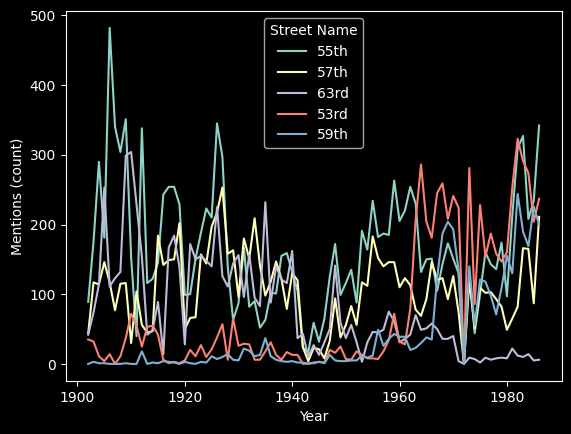

In [64]:
plt.style.use('dark_background')

labels = {name:re.sub(' st', '', name) for name in common_names}

fig, ax = plt.subplots()

for col in cnts_by_year.drop('Year', axis=1).columns:
    ax.plot(cnts_by_year['Year'], cnts_by_year[col], label=labels[col])

ax.legend(title='Street Name')
ax.set_ylabel('Mentions (count)')
ax.set_xlabel('Year')

That's a little hard to read, so let's aggregate up to, say, five year intervals:

C:\Users\wimer\AppData\Local\Temp\ipykernel_40664\2773748414.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnts_by_bin = cnts_by_year.groupby('Year_Bin').sum().reset_index()


Text(0.5, 1.0, 'Shifting Connections: Mentions of Streets in the Daily Maroon')

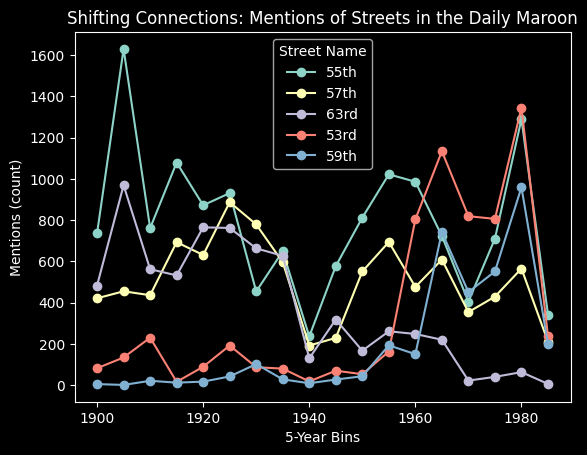

In [78]:
bins = [1900 + 5*i for i in range(20)]

cnts_by_year['Year_Bin'] = pd.cut(cnts_by_year['Year'], bins, labels=bins[:-1])
cnts_by_bin = cnts_by_year.groupby('Year_Bin').sum().reset_index()

plt.style.use('dark_background')

labels = {name:re.sub(' st', '', name) for name in common_names}

fig, ax = plt.subplots()

for col in cnts_by_bin.drop(['Year', 'Year_Bin'], axis=1).columns:
    ax.plot(cnts_by_bin['Year_Bin'][:-1], cnts_by_bin[col][:-1], 'o-', label=labels[col])

ax.legend(title='Street Name')
ax.set_ylabel('Mentions (count)')
ax.set_xlabel('5-Year Bins')
ax.set_title('Shifting Connections: Mentions of Streets in the Daily Maroon')

plt.savefig('../img/shiftingconnections.png', dpi=600)